<h1>Задача для коллоквиума №1.</h1>

Сравнение квантового основного уравнения с алгоритмом вычисления эволюции вектора состояния.

Квантовое основное уравнение: $$i\hbar\dot{\rho}=[H, \rho]+i\mathcal{L}(\rho)$$
где $\mathcal{L}(\rho)=\sum_j \gamma_j(A_j\rho A_j^{+} - \frac{1}{2} \{A_j^{+}A_j, \rho\})$

Матричное дифференциальное уравнение можно промоделировать следующим образом:
$$\rho(t+\Delta t) = \rho(t) - \frac{i\Delta t}{\hbar} [H, \rho] + \frac{\Delta t}{\hbar}\mathcal{L}(\rho)$$

А эволюцию для состояния $\psi$ можно промоделировать следующим образом:
$$\psi(t+\Delta t) = (I - \frac{i\Delta t}{\hbar} H) \psi + \frac{\Delta t}{\hbar}\mathcal{L}(\psi)$$

Исследуем на простейшей задаче на ассоциацию:
Базис: $|m>_{фон}|cov>$
$m=0,1$
$cov=1$ - нет ковалентной связи, $cov=0$ - есть ковалентная связь
$\gamma_0=const$

Единственный фактор декогерентности:
$$A_0=b=\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}$$

Получаем оператор Линблада для первого случая: $\mathcal{L}(\rho) = \gamma_0(b\rho b^{+}-\frac{1}{2}\{b^{+}b, \rho\})$
Получаем оператор Линблада для второго случая: $\mathcal{L}(\psi) = \gamma_0(b\psi)$

$$H = \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & \hbar\omega & g_{cov} & 0 \\
0 & g_{cov} & \hbar\omega & 0 \\
0 & 0 & 0 & \hbar\omega \\
\end{pmatrix}$$

References:
https://vql.cs.msu.ru/quantum%20computations%20course%20rus.pdf
https://arxiv.org/pdf/1906.04478.pdf

In [28]:
import numpy as np
import matplotlib.pyplot as plt

ozhigov@cs.msu.ru

In [45]:
def quantum_state(state, sorted_states):
        pos = -1
        for idx, cur_state in enumerate(sorted_states):
            if np.array_equal(state, cur_state):
                pos = idx
        n = len(sorted_states_list)
        result = np.zeros(n).astype(np.cdouble)
        if pos == -1:
            return None
        result[pos] = 1
        return result.reshape((-1, 1))


def get_density_from_state(state):
    return np.multiply(state, np.conjugate(state)[:,0])


def get_commutator(first_matrix, second_matrix):
    return np.dot(first_matrix, second_matrix) - np.dot(second_matrix, first_matrix)


def get_anti_commutator(first_matrix, second_matrix):
    return np.dot(first_matrix, second_matrix) + np.dot(second_matrix, first_matrix)


def get_rho_norm(rho):
    norm1_rho = (rho + np.conjugate(rho).T) / 2
    norm2_rho = norm1_rho / np.sum(np.abs(np.diag(norm1_rho)))
    return norm2_rho


def get_state_norm(state):
    return state / np.linalg.norm(np.abs(state[:,0]))


def complex_conjugate(matrix):
    return np.conjugate(matrix).T


def get_probability_from_density(density_matrix, wanted_state):
    return float(np.linalg.norm(np.diagonal(density_matrix) * wanted_state[:,0]))


def get_probability_from_state(state, wanted_state):
    #filtered_array = state[:, 0] * wanted_state[:, 0]
    #filtered_array = np.abs(filtered_array)
    #filtered_array **= 2
    #return float(filtered_array.sum())
    return float(np.linalg.norm(np.dot(state[:,0], wanted_state[:,0])) ** 2)

In [46]:
def get_hamiltonian(h, w, g_c):
    return np.array([[0, 0, 0, 0],
                     [0, h*w, g_c, 0],
                     [0, g_c, h*w, 0],
                     [0, 0, 0, h*w]]).astype(np.cdouble)

In [47]:
def get_graph(init_state_base, mol_state_base, h_const, gamma_const, time_delta, t_max, b_const, h, w, g_c):
    H_matrix = get_hamiltonian(h, w, g_c)

    latest_rho_first = get_density_from_state(init_state_base)
    latest_state_second = init_state_base

    b_cross_const = complex_conjugate(b_const)
    b_cross_b_const = b_cross_const @ b_const

    cur_t = 0
    t_list = []
    first_solution_list = []
    second_solution_list = []
    percents_to_print = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    latest_percent_done = -1

    while cur_t < t_max:
        # Main Equation Solution
        first_solution = get_probability_from_density(latest_rho_first, mol_state_base)
        first_liouville = gamma_const * (b_const @ latest_rho_first @ b_cross_const - 0.5 * get_anti_commutator(b_cross_b_const, latest_rho_first))
        latest_rho_first = latest_rho_first - (1j * time_delta / h_const) * get_commutator(H_matrix, latest_rho_first) + time_delta / h_const * first_liouville
        latest_rho_first = get_rho_norm(latest_rho_first)
        # Evolution Modeling Solution
        second_solution = get_probability_from_state(latest_state_second, mol_state_base)
        second_liouville = gamma_const * (np.dot(b_const, latest_state_second))
        latest_state_second = np.dot(np.identity(4) - 1j * time_delta / h_const * H_matrix, latest_state_second) + time_delta / h_const * second_liouville
        latest_state_second = get_state_norm(latest_state_second)
        # print
        cur_percent = round(cur_t * 100 / t_max)
        if cur_percent != latest_percent_done and cur_percent in percents_to_print:
            print(f"Done {cur_percent}%", cur_t, first_solution, second_solution)
            print(np.diag(latest_rho_first))
            print(latest_state_second)
            latest_percent_done = cur_percent
        first_solution_list.append(first_solution)
        second_solution_list.append(second_solution)
        t_list.append(cur_t)
        cur_t += time_delta
    return t_list, first_solution_list, second_solution_list

In [56]:
def print_graph(t, list_of_values):
    for values_list, values_name in list_of_values:
        plt.plot(t, values_list, label=values_name)
    plt.title("Moleculo Appearance Probability")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend(loc="lower right")
    plt.show()

In [57]:
sorted_states_list = [np.array([0, 0]).astype(np.cdouble).reshape((-1, 1)),
                      np.array([0, 1]).astype(np.cdouble).reshape((-1, 1)),
                      np.array([1, 0]).astype(np.cdouble).reshape((-1, 1)),
                      np.array([1, 1]).astype(np.cdouble).reshape((-1, 1))]

initial_state_base = quantum_state(np.array([0, 1]).astype(np.cdouble).reshape((-1, 1)), sorted_states_list)
moleculo_state_base = quantum_state(np.array([0, 0]).astype(np.cdouble).reshape((-1, 1)), sorted_states_list)

b = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0],
              [0, 0, 0, 0]]).astype(np.cdouble)

Done 0% 0 0.0 0.0
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[[0.        +0.0000000e+00j]
 [0.99999999-9.9999999e-05j]
 [0.        -9.9999999e-05j]
 [0.        +0.0000000e+00j]]
Done 1% 0.10000000000000184 0.0003195598527338801 2.489390485701823e-05
[3.20507273e-04+0.j 9.90186856e-01+0.j 9.49263671e-03+0.j
 0.00000000e+00+0.j]
[[-3.32662802e-04-0.00498828j]
 [ 9.90000940e-01-0.09943242j]
 [-9.97655284e-03-0.09943242j]
 [ 0.00000000e+00+0.j        ]]
Done 2% 0.30009999999998327 0.007913581043900272 0.001982195819523543
[0.00792112+0.j 0.91669396+0.j 0.07538492+0.j 0.        +0.j]
[[-0.00883933-0.04366548j]
 [ 0.91164615-0.28221427j]
 [-0.08733096-0.28221427j]
 [ 0.        +0.j        ]]
Done 5% 0.9000999999999172 0.15040119335908927 0.12034035407221089
[0.15044103+0.j 0.45114689+0.j 0.39841208+0.j 0.        +0.j]
[[-0.19376429-0.28781677j]
 [ 0.36216097-0.45667404j]
 [-0.57563354-0.45667404j]
 [ 0.        +0.j        ]]
Done 10% 1.9000999999998072 0.6165543348761268 0.5862349564473539
[6.16592676e-0

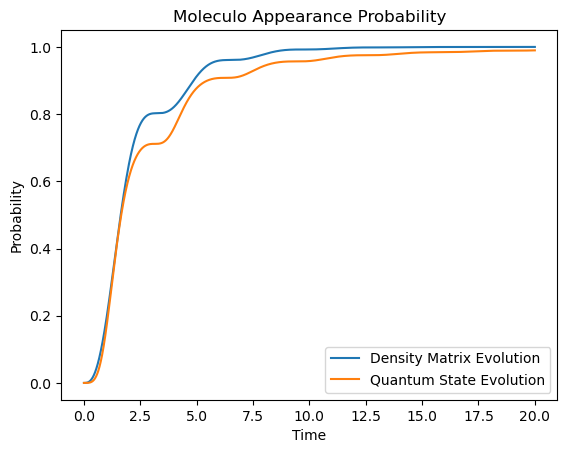

In [58]:
%matplotlib inline
# %matplotlib notebook
t_lst, first_solution_lst, second_solution_lst = get_graph(init_state_base=initial_state_base,
                                                           mol_state_base=moleculo_state_base,
                                                           b_const=b,
                                                           h_const=1,
                                                           gamma_const=1,
                                                           g_c=1,
                                                           time_delta=1e-4,
                                                           t_max=20,
                                                           h=1,
                                                           w=1)

print_graph(t_lst, [(first_solution_lst, "Density Matrix Evolution"), (second_solution_lst, "Quantum State Evolution")])

Done 0% 0 0.0 0.0
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[[0.        +0.0000000e+00j]
 [0.99999999-9.9999999e-05j]
 [0.        -9.9999999e-05j]
 [0.        +0.0000000e+00j]]
Done 1% 0.10000000000000184 0.00232053721985514 0.00248327047410907
[0.00232671+0.j 0.99149283+0.j 0.00618047+0.j 0.        +0.j]
[[-0.00332252-0.04982116j]
 [ 0.9887784 -0.09930963j]
 [-0.00996423-0.09930963j]
 [ 0.        +0.j        ]]
Done 2% 0.30009999999998327 0.03320233607004903 0.16570254721193034
[0.0332258 +0.j 0.94330674+0.j 0.02346746+0.j 0.        +0.j]
[[-0.08080974-0.39919272j]
 [ 0.83343298-0.25800216j]
 [-0.07983854-0.25800216j]
 [ 0.        +0.j        ]]
Done 5% 0.9000999999999172 0.2186291658443958 0.9318816463988517
[0.21866082+0.j 0.74968366+0.j 0.03165552+0.j 0.        +0.j]
[[-0.53910993-0.80079195j]
 [ 0.10076396-0.12706032j]
 [-0.16015839-0.12706032j]
 [ 0.        +0.j        ]]
Done 10% 1.9000999999998072 0.48391165139180525 0.992991459313512
[0.48393319+0.j 0.49453144+0.j 0.02153537+0.j 0.       

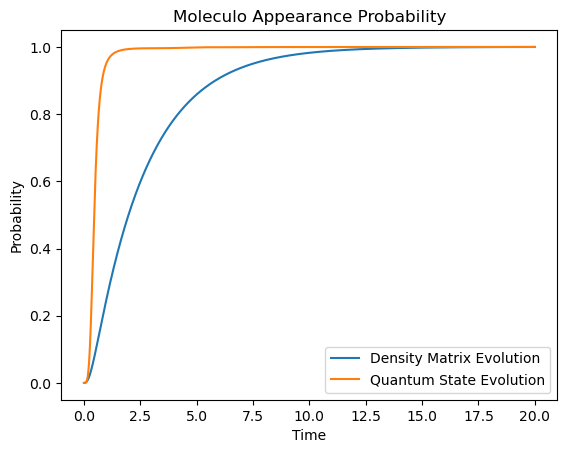

In [60]:
%matplotlib inline
# %matplotlib notebook
t_lst, first_solution_lst, second_solution_lst = get_graph(init_state_base=initial_state_base,
                                                           mol_state_base=moleculo_state_base,
                                                           b_const=b,
                                                           h_const=1,
                                                           gamma_const=10,
                                                           g_c=1,
                                                           time_delta=1e-4,
                                                           t_max=20,
                                                           h=1,
                                                           w=1)

print_graph(t_lst, [(first_solution_lst, "Density Matrix Evolution"), (second_solution_lst, "Quantum State Evolution")])

In [ ]:
%matplotlib inline
# %matplotlib notebook
t_lst, first_solution_lst, second_solution_lst = get_graph(init_state_base=initial_state_base,
                                                           mol_state_base=moleculo_state_base,
                                                           b_const=b,
                                                           h_const=1,
                                                           gamma_const=100,
                                                           g_c=1,
                                                           time_delta=1e-4,
                                                           t_max=20,
                                                           h=1,
                                                           w=1)

print_graph(t_lst, [(first_solution_lst, "Density Matrix Evolution"), (second_solution_lst, "Quantum State Evolution")])

Done 0% 0 0.0 0.0
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[[0.        +0.j      ]
 [0.99990001-0.009999j]
 [0.        -0.009999j]
 [0.        +0.j      ]]
Done 1% 0.10999999999999999 0.00031989961258632494 3.0146346018068275e-05
[4.24808627e-04+0.j 9.87056178e-01+0.j 1.25190132e-02+0.j
 0.00000000e+00+0.j]
[[-4.38829683e-04-0.00657217j]
 [ 9.85633509e-01-0.11897568j]
 [-1.31443456e-02-0.11897568j]
 [ 0.00000000e+00+0.j        ]]
Done 2% 0.3000000000000001 0.007243371047917066 0.0018483927801342642
[0.00798155+0.j 0.9136436 +0.j 0.07837485+0.j 0.        +0.j]
[[-0.00881811-0.04506507j]
 [ 0.90571411-0.29107549j]
 [-0.09013014-0.29107549j]
 [ 0.        +0.j        ]]
Done 5% 0.9000000000000006 0.1483178226757031 0.11748879154748641
[0.15233524+0.j 0.44134947+0.j 0.40631529+0.j 0.        +0.j]
[[-0.19338795-0.29040004j]
 [ 0.3477953 -0.4582459j ]
 [-0.58080008-0.4582459j ]
 [ 0.        +0.j        ]]
Done 10% 1.9000000000000015 0.6114045916672262 0.5802374717698843
[ 0.61551553+0.j -0.00692522+0.j 

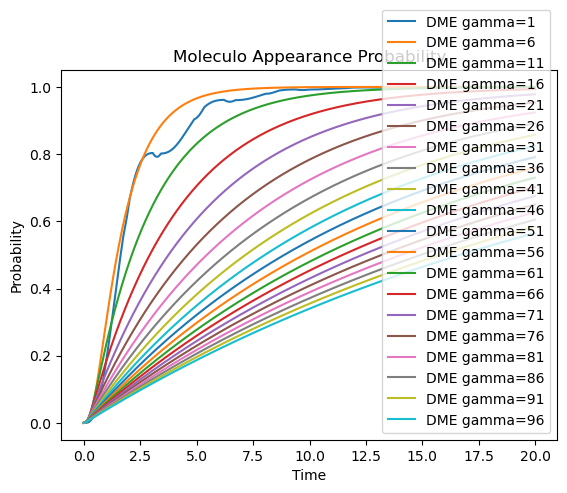

In [68]:
lst_of_values = []
for alpha in range(1, 100, 5):
    t_lst, first_solution_lst, second_solution_lst = get_graph(init_state_base=initial_state_base,
                                                           mol_state_base=moleculo_state_base,
                                                           b_const=b,
                                                           h_const=1,
                                                           gamma_const=alpha,
                                                           g_c=1,
                                                           time_delta=1e-2,
                                                           t_max=20,
                                                           h=1,
                                                           w=1)
    lst_of_values.append((first_solution_lst, f"DME gamma={alpha}"))
print_graph(t_lst, lst_of_values)